In [54]:
import string
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
from matplotlib import animation, rc, colors
import brian2.units as bunits
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid, AxesGrid
import traceback
import os
import copy
from datetime import datetime
from brian2.units import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ensure we use viridis as the default cmap
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [84]:
# ensure we use the same rc parameters for all matplotlib outputs
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})
mlib.rcParams.update({'figure.figsize': (5,10)})

In [85]:
def get_ordered_layer_names(dictionary):
    layer_names = list(dictionary)
    print(layer_names)
    layer_names.sort()
    layer_names[0] = layer_names.pop(-1)
    return layer_names

def get_ordered_layer_names_from_data(data, spikes_dict=None):
    if spikes_dict is None:
        spikes_dict = reconstruct_spikes_dict(data)
    dictionary = spikes_dict.keys()
    return get_ordered_layer_names(dictionary)
    
def get_shape_from_name(name):
    shape_string = name.split('_')
    if len(shape_string) <2:
        return
    else:
        shape_string = shape_string[1]
    shape_list = shape_string.split('x')
    return tuple([int(item) for item in shape_list])

def reconstruct_spikes_dict(data):
    '''This is necessary due to serialisation problems is spikes_dict is packaged into an array.'''
    expected_files = ['N_layer', 'y_test', 'output_v', 'runtime', 't_stim', 'neo_spikes_dict', 'sim_time']
    unexpected_files = [file for file in data.files if file not in expected_files]
    spike_dict = {file_name:data[file_name] for file_name in unexpected_files}
    return spike_dict

In [86]:
# data = np.load("mnist_results__235237_08072019.npz")

# data = np.load("mnist_results_ed_mnist_network_test_100_full_recordings.npz")
#data = np.load('results/output_t_stim_1000_testing_examples_10_tsf_100.npz')
#data = np.load('results/output_t_stim_300_testing_examples_10_tsf_100_reset_by_subtraction.npz')#
data = np.load('results/output_t_stim_2000_testing_examples_1.npz')
#data = np.load("results/output_t_stim_80_testing_examples_50.npz")
#data= np.load("results/output2.npz")
#data= np.load("results/output_t_stim_800_testing_examples_20.npz")
#"..//pynn_object_serialisation/pynn_object_serialisation/"
#"experiments/mnist_testing/results/mnist_results_ed_mnist_network_test_1.npz")
# data = np.load("mnist_results_ed_mnist_network_test.npz")

In [87]:
data.files

['04Conv2D_16x16x128',
 '06Conv2D_8x8x256',
 '10Conv2D_1x1x10',
 'neo_spikes_dict',
 '01DepthwiseConv2D_32x32x32',
 '05DepthwiseConv2D_8x8x128',
 '07AveragePooling2D_256',
 '03DepthwiseConv2D_16x16x64',
 'InputLayer',
 'output_v',
 'N_layer',
 '00Conv2D_32x32x32',
 't_stim',
 'y_test',
 '02Conv2D_32x32x64',
 'sim_time',
 'runtime']

In [88]:
reconstruct_spikes_dict(data)

{'00Conv2D_32x32x32': array([[    0.,    92.],
        [    0.,    93.],
        [    0.,    94.],
        ...,
        [32734.,  1997.],
        [32734.,  1998.],
        [32734.,  1999.]]),
 '01DepthwiseConv2D_32x32x32': array([[    0.,   111.],
        [    0.,   112.],
        [    0.,   113.],
        ...,
        [31742.,  1997.],
        [31742.,  1998.],
        [31742.,  1999.]]),
 '02Conv2D_32x32x64': array([[1.0000e+00, 4.3700e+02],
        [1.0000e+00, 4.3800e+02],
        [1.0000e+00, 4.3900e+02],
        ...,
        [6.5535e+04, 1.9970e+03],
        [6.5535e+04, 1.9980e+03],
        [6.5535e+04, 1.9990e+03]]),
 '03DepthwiseConv2D_16x16x64': array([[   31.,   253.],
        [   31.,   254.],
        [   31.,   255.],
        ...,
        [16369.,  1979.],
        [16369.,  1980.],
        [16369.,  1981.]]),
 '04Conv2D_16x16x128': array([[    0.,   557.],
        [    0.,   558.],
        [    0.,   559.],
        ...,
        [32758.,  1997.],
        [32758.,  1998.],
 

In [89]:
input_layer_name = 'InputLayer'
spikes_dict = reconstruct_spikes_dict(data)
output_layer_name = get_ordered_layer_names_from_data(data, spikes_dict)[-1]
y_test = data['y_test']

t_stim=data['t_stim']
runtime=int(data['runtime'])
N_layer=int(data['N_layer'])
neo_object = data['neo_spikes_dict']

data.close()

labels = np.load('/mnt/snntoolbox/snn_toolbox_private/examples/models/05-mobilenet_dwarf_v1/label_names.npz')
label_names = labels['arr_0']
labels.close()

x_test_file = np.load('/mnt/snntoolbox/snn_toolbox_private/examples/models/05-mobilenet_dwarf_v1/x_test.npz')
x_test = x_test_file['arr_0']
x_test_file.close()


['03DepthwiseConv2D_16x16x64', '06Conv2D_8x8x256', '10Conv2D_1x1x10', '00Conv2D_32x32x32', '04Conv2D_16x16x128', '02Conv2D_32x32x64', '01DepthwiseConv2D_32x32x32', '07AveragePooling2D_256', 'InputLayer', '05DepthwiseConv2D_8x8x128']


In [90]:
spikes_dict

{'00Conv2D_32x32x32': array([[    0.,    92.],
        [    0.,    93.],
        [    0.,    94.],
        ...,
        [32734.,  1997.],
        [32734.,  1998.],
        [32734.,  1999.]]),
 '01DepthwiseConv2D_32x32x32': array([[    0.,   111.],
        [    0.,   112.],
        [    0.,   113.],
        ...,
        [31742.,  1997.],
        [31742.,  1998.],
        [31742.,  1999.]]),
 '02Conv2D_32x32x64': array([[1.0000e+00, 4.3700e+02],
        [1.0000e+00, 4.3800e+02],
        [1.0000e+00, 4.3900e+02],
        ...,
        [6.5535e+04, 1.9970e+03],
        [6.5535e+04, 1.9980e+03],
        [6.5535e+04, 1.9990e+03]]),
 '03DepthwiseConv2D_16x16x64': array([[   31.,   253.],
        [   31.,   254.],
        [   31.,   255.],
        ...,
        [16369.,  1979.],
        [16369.,  1980.],
        [16369.,  1981.]]),
 '04Conv2D_16x16x128': array([[    0.,   557.],
        [    0.,   558.],
        [    0.,   559.],
        ...,
        [32758.,  1997.],
        [32758.,  1998.],
 

In [91]:
t_stim

array(2000)

In [92]:
def get_bounds(bin_number, t_stim =t_stim):
    #delay = get_propagation_delay(t_stim, N_layers)
    delay =0
    lower_end_bin_time = bin_number * t_stim + delay 
    higher_end_bin_time = (bin_number+1) * t_stim + delay
    '''maximum_time = t_stim * maximum_bins
    if higher_end_bin_time > maximum_time:
        higher_end_bin_time = maximum_time
        print('Final bin cutoff.')'''
    return lower_end_bin_time, higher_end_bin_time

def get_bin_spikes(spikes, bin_number):
    lower_end_bin_time, higher_end_bin_time = get_bounds(bin_number)
    output = spikes[np.where((spikes[:,1] >= lower_end_bin_time) & (spikes[:,1] < higher_end_bin_time)),:]
    output = np.asarray(output).astype(int)
    return output

def get_counts(spikes, bin_number, t_stim=t_stim, minlength = 3*32**2):
    spikes = get_bin_spikes(spikes, bin_number)
    just_spikes = spikes.reshape((-1,2))[:,0]
    counts = np.bincount(just_spikes, minlength=minlength)
    return counts

def get_rates(spikes, bin_number, t_stim=t_stim):
    return get_counts(spikes, bin_number)/t_stim

def plot_rates(rates, shape=(32,32,3)):
    rates /= rates.max()
    plt.imshow(rates.reshape(shape))
    
def plot_bin(spikes, bin_number):
    plot_rates(get_rates(spikes, bin_number))
    
def get_propagation_delay(tim_stim, N_layers, dt=1, delays=False):
    if delays:
        raise Exception('Cannnot currently calculate model with delays')
    else:
        return (N_layers-1)*dt
    
def get_prediction(spikes, bin_number, t_stim=t_stim, output_size=10):
    counts = get_counts(spikes, bin_number, t_stim, 10)
    if counts.max() > 0:
        return np.argmax(counts)
    else:
        return -1

In [93]:
input_layer_name = get_ordered_layer_names(spikes_dict)[0]
output_layer_name = get_ordered_layer_names(spikes_dict)[-1]
input_layer_shape = (32, 32, 3)
input_spikes = spikes_dict[input_layer_name]
output_spikes = spikes_dict[output_layer_name]
last_but_one = spikes_dict[get_ordered_layer_names(spikes_dict)[-2]]

['03DepthwiseConv2D_16x16x64', '06Conv2D_8x8x256', '10Conv2D_1x1x10', '00Conv2D_32x32x32', '04Conv2D_16x16x128', '02Conv2D_32x32x64', '01DepthwiseConv2D_32x32x32', '07AveragePooling2D_256', 'InputLayer', '05DepthwiseConv2D_8x8x128']
['03DepthwiseConv2D_16x16x64', '06Conv2D_8x8x256', '10Conv2D_1x1x10', '00Conv2D_32x32x32', '04Conv2D_16x16x128', '02Conv2D_32x32x64', '01DepthwiseConv2D_32x32x32', '07AveragePooling2D_256', 'InputLayer', '05DepthwiseConv2D_8x8x128']
['03DepthwiseConv2D_16x16x64', '06Conv2D_8x8x256', '10Conv2D_1x1x10', '00Conv2D_32x32x32', '04Conv2D_16x16x128', '02Conv2D_32x32x64', '01DepthwiseConv2D_32x32x32', '07AveragePooling2D_256', 'InputLayer', '05DepthwiseConv2D_8x8x128']


In [94]:
output_labels, output_counts = np.unique(output_spikes[:,0], return_counts=True)

In [95]:
label_names = [name.decode('utf-8') for name in label_names]

([<matplotlib.axis.XTick at 0x7f16ca4f09b0>,
 <a list of 3 Text xticklabel objects>)

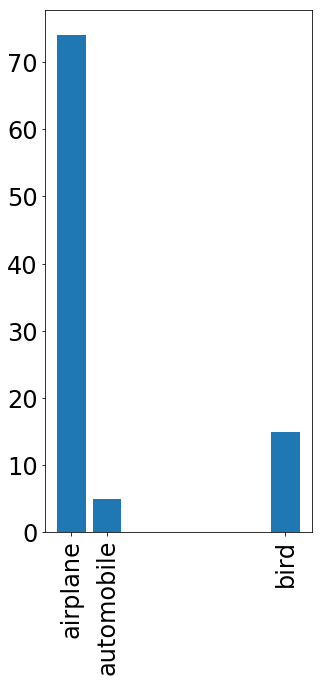

In [96]:
plt.bar(output_labels, output_counts)
plt.xticks(output_labels, label_names, rotation=90)

In [97]:
plt.bar(np.arange(len(output_label), np.unique(output_spikes[:,0])

label_names[int(output_labels[np.argmax(output_counts)])]

SyntaxError: invalid syntax (<ipython-input-97-326852e4dbc3>, line 3)

In [26]:
number_of_examples = runtime // t_stim
actual_test_labels = y_test[:number_of_examples].ravel()
y_pred = np.ones(number_of_examples) * (-1)
output_spikes = spikes_dict[output_layer_name]
for bin_number in range(number_of_examples):
    y_pred[bin_number]=get_prediction(output_spikes, bin_number)

In [27]:
print("Accuracy", np.count_nonzero(y_pred==actual_test_labels)/float(number_of_examples))

Accuracy 1.0


In [28]:
for i in range(number_of_examples):
    prediction = get_prediction(output_spikes, i)
    predicted_label = label_names[prediction].decode('UTF-8')
    actual_label = label_names[actual_test_labels[i]].decode('UTF-8')
    print("Predicted: {}, Actual: {}".format(predicted_label, actual_label))
    #plot_bin(input_spikes, i)
    #plt.show()

Predicted: cat, Actual: cat


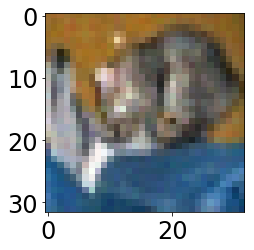

In [29]:
bin_number = 0

prediction = get_prediction(output_spikes, bin_number)
label_names[prediction]
plot_bin(input_spikes, bin_number)
plt.show()

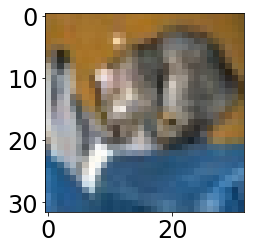

In [30]:
plt.imshow(x_test[bin_number])

In [31]:
rates = get_rates(input_spikes, bin_number).reshape((32,32,3))
rates /= rates.max()

In [32]:
real = x_test[bin_number]

real.max()

1.0

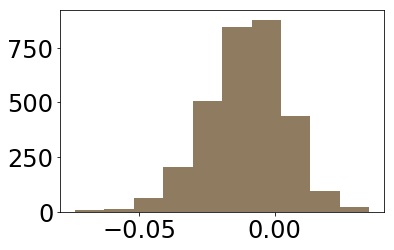

In [33]:
real_int8 = real / 255.
real_emp = real / real.max()

difference = rates-real_emp
difference_emp = rates - real_emp
plt.hist(difference.ravel(), alpha=1)
plt.hist(difference_emp.ravel(), alpha=0.5)
plt.savefig("difference_histogram_ten_seconds.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


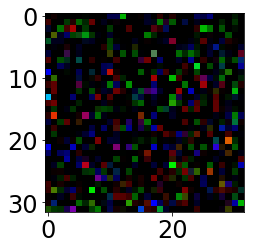

In [34]:
difference /= difference.max()
plt.imshow(difference)

In [35]:
t_stim

array(2000)

In [36]:
nid_bincount = get_counts(output_spikes, 0, t_stim, 10)
print(nid_bincount)
print("Count: Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))
nid_bincount = nid_bincount/(t_stim * ms)
print("Hz   : Min", np.min(nid_bincount), "Max", np.max(nid_bincount), "Mean", np.mean(nid_bincount))

[ 0  0  0 74  5  0  0  0  0 15]
Count: Min 0 Max 74 Mean 9.4
Hz   : Min 0. Hz Max 37. Hz Mean 4.7 Hz


In [37]:
for i in range(number_of_examples):
    print (np.max(get_counts(output_spikes, i)))

74
